In [1]:
import numpy as np
import matplotlib as mplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sample_set1 = np.loadtxt("output1")
sample_set1.shape
print sample_set1

sample_set2 = np.loadtxt("output2")
sample_set2.shape
print sample_set2

sample_set3 = np.loadtxt("output3")
sample_set3.shape
print sample_set3

# case 1
case1_sample_set = np.vstack((sample_set1,sample_set2))
labels = np.array([0]*10000 + [1]*10000)

# case 2
case2_sample_set = np.vstack((sample_set1,sample_set3))

[[ 0.809228  0.957392]
 [ 0.144806  1.52743 ]
 [ 1.21765   1.98139 ]
 ..., 
 [ 1.12203   1.10634 ]
 [ 1.39213   1.98418 ]
 [ 0.752019  1.9806  ]]
[[ 5.30461  4.48895]
 [ 4.36356  4.17231]
 [ 5.29001  3.37141]
 ..., 
 [ 5.21185  3.15746]
 [ 2.59524  4.8156 ]
 [ 3.31514  3.63965]]
[[  2.612     8.11091]
 [  4.20989  -1.53592]
 [  4.57088  11.2334 ]
 ..., 
 [  2.47909   4.91276]
 [  5.19069   1.64224]
 [  4.79315   1.26729]]


In [99]:
class QuadraticDiscriminant:
    def __init__(self, mean1, mean2, cov1, cov2, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.cov1 = cov1
        self.cov2 = cov2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        
        conv1_inv = np.linalg.inv(self.cov1)
        conv2_inv = np.linalg.inv(self.cov2)
        
        self.W1 = -0.5*conv1_inv
        self.W2 = -0.5*conv2_inv
        self.w1 = np.dot(conv1_inv,self.mean1)
        self.w2 = np.dot(conv2_inv,self.mean2)
        
        part11 = -0.5*np.dot(np.dot(self.mean1, conv1_inv),self.mean1)
        part12 = -0.5*np.log(np.linalg.det(conv1_inv))+np.log(self.apriori1)
        self.w10 = part11 + part12
        
        part21 = -0.5*np.dot(np.dot(self.mean2, conv2_inv),self.mean2)
        part22 = -0.5*np.log(np.linalg.det(conv2_inv))+np.log(self.apriori2)
        self.w20 = part21 + part22
        
    def predict(self, X):
        labels = []
        for x in X:
            g1 = np.dot(np.dot(x,self.W1),x)+np.dot(self.w1,x)+self.w10
            g2 = np.dot(np.dot(x,self.W2),x)+np.dot(self.w2,x)+self.w20
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)

In [4]:
def calcError(classifier, X, Y):
    # calculate the number of misclassified samples separately and in total
    miss_total = 0
    miss_class1 = 0
    miss_class2 = 0
    predicted_labels = classifier.predict(X)

    for n in range(Y.size):
        if predicted_labels[n] != Y[n]:
            if Y[n] == 0:
                miss_class1 += 1
            else:
                miss_class2 += 1

    miss_total = miss_class1 + miss_class2

    print "# of miss classifications for class1 = %d" %(miss_class1)
    print "# of miss classifications for class2 = %d" %(miss_class2)
    print "# of miss classifications = %d" %(miss_total)

In [73]:
def visualize(classifier, X, Y, ax):
    # Show how points in a grid would be classified
    h = 0.05 # mesh size
    x_min, x_max = X[:, 0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap='cool')
    
    # Plots the training data
    ax.scatter(X[:,0],  X[:,1], c = Y, cmap='cool')
    
# error bounds
def kb(beta, mean1, mean2, cov1, cov2):
    diff = mean1 - mean2
    covline = (1-beta)*cov1+beta*cov2
    part1 =  beta*(1-beta)/2.0*np.dot(np.dot(np.linalg.inv(covline),diff),diff)
    part2 = 0.5*(np.log(np.linalg.det(covline)) - np.log(np.linalg.det(cov1)**(1-beta)*np.linalg.det(cov2)**beta))
    kb = part1 + part2
    return kb

def ekb(beta, mean1, mean2, cov1, cov2):
    return np.exp(-kb(beta, mean1, mean2, cov1, cov2))

def chernoff(beta, apriori1, apriori2, ekb):
    return (apriori1**beta)*(apriori2**(1-beta))*ekb
    
def bhattacharyya(apriori1, apriori2, ekb):
    return sqrt(apriori1*apriori2)*ekb

# 1. Part A

In [20]:
# minimum distance classifier
class MinDistClassifier:
    def __init__(self, mean1, mean2):
        self.mean1 = mean1
        self.mean2 = mean2
        
    def predict(self, X):
        labels = []
        for x in X:
            diff1 = x-self.mean1
            diff2 = x-self.mean2
            g1 = -np.sum(diff1*diff1)
            g2 = -np.sum(diff2*diff2)
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)
    
class CaseIClassifier:
    def __init__(self, mean1, mean2, var, apriori1, apriori2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.apriori1 = apriori1
        self.apriori2 = apriori2
        self.var = var
        
    def predict(self, X):
        labels = []
        for x in X:
            diff1 = x-self.mean1
            diff2 = x-self.mean2
            g1 = -np.sum(diff1*diff1)/(2*self.var**2) + np.log(self.apriori1)
            g2 = -np.sum(diff2*diff2)/(2*self.var**2) + np.log(self.apriori2)
            
            if g1 > g2:
                labels.append(0)
            else:
                labels.append(1)
        return np.array(labels)

In [63]:
# make classifier
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
apriori1 = 0.5
apriori2 = 0.5
var = 1.
cov = np.array([[var,0],[0,var]])
classifier1 = MinDistClassifier(mean1, mean2)

# calc miss classification
calcError(classifier1, case1_sample_set, labels)


# of miss classifications for class1 = 182
# of miss classifications for class2 = 164
# of miss classifications = 346


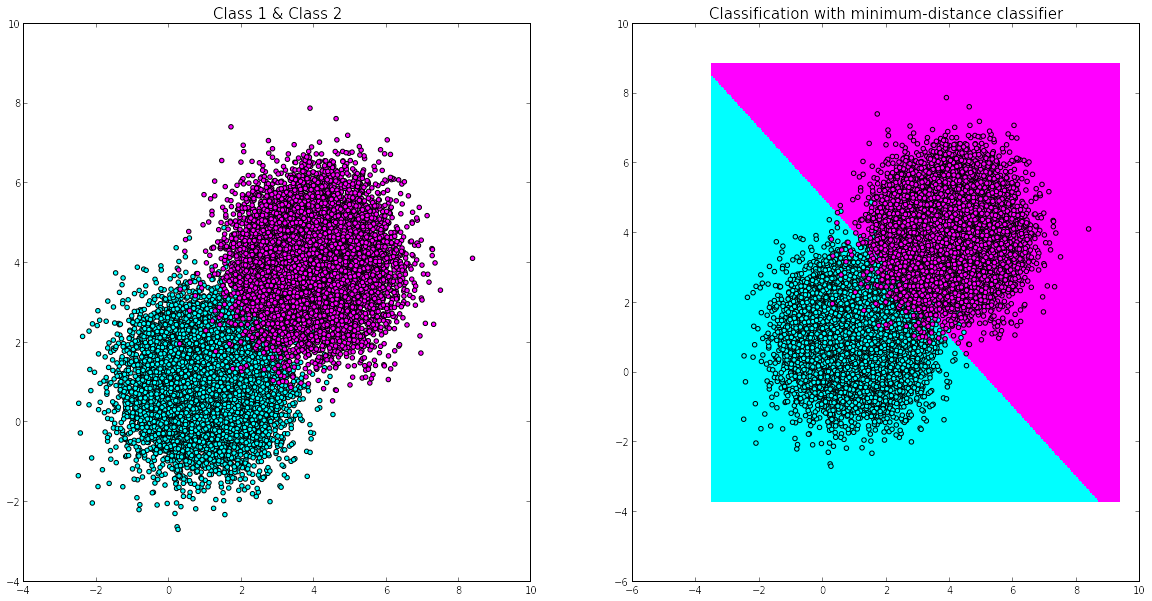

In [22]:
f, axarr = subplots(1, 2,figsize=(20,10))
axarr[0].set_title("Class 1 & Class 2", fontsize=15)
axarr[0].scatter(case1_sample_set[:,0], case1_sample_set[:,1], c=labels, cmap='cool')

axarr[1].set_title("Classification with minimum-distance classifier", fontsize=15)
visualize(classifier1, case1_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.052700
Bhattacharyya bound: 
k(0.5) = 2.250000
P(error) <= 0.052700


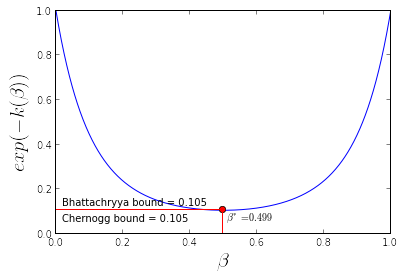

In [71]:
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
apriori1 = 0.5
apriori2 = 0.5
var = 1.
cov = np.array([[var,0],[0,var]])

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value-0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov, cov)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))


# 1. Part B

In [67]:
# make classifier
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
apriori1 = 0.3
apriori2 = 0.7
var = 1.
cov = np.array([[var,0],[0,var]])
classifier2 = CaseIClassifier(mean1, mean2, var, apriori1, apriori2)

# calc miss classification
calcError(classifier2, case1_sample_set, labels)

# of miss classifications for class1 = 279
# of miss classifications for class2 = 96
# of miss classifications = 375


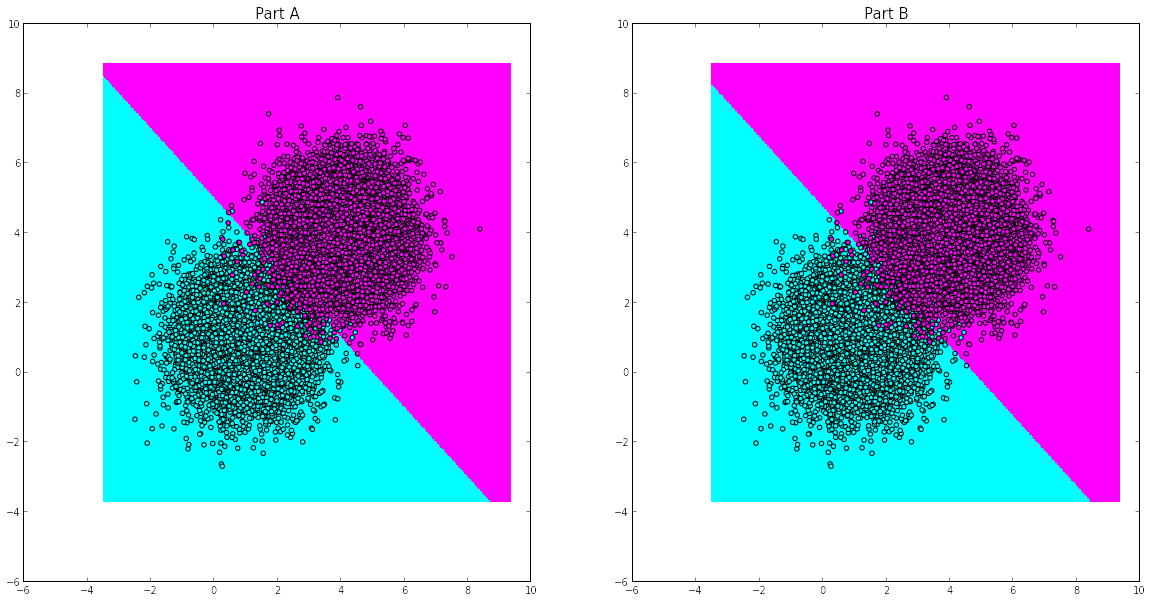

In [68]:
f, axarr = subplots(1, 2,figsize=(20,10))
axarr[0].set_title("Part A", fontsize=15)
visualize(classifier1, case1_sample_set, labels, axarr[0])

axarr[1].set_title("Part B", fontsize=15)
visualize(classifier2, case1_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.048321
Bhattacharyya bound: 
k(0.5) = 2.250000
P(error) <= 0.048300


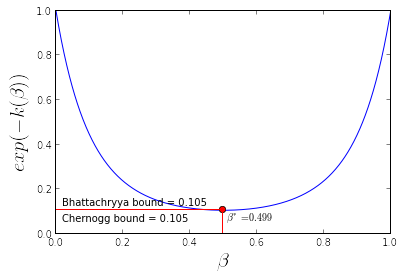

In [72]:
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
apriori1 = 0.3
apriori2 = 0.7
var = 1.
cov = np.array([[var,0],[0,var]])

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value-0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov, cov)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 2. Part A

In [103]:
# make classifier 
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
cov1 = np.array([[1.,0],[0,1.]])
cov2 = np.array([[4.,0],[0,16.]])
apriori1 = 0.5
apriori2 = 0.5

classifier1 = QuadraticDiscriminant(mean1, mean2, cov1, cov2, apriori1, apriori2)

# calc miss classification
calcError(classifier1, case2_sample_set, labels)

# of miss classifications for class1 = 10000
# of miss classifications for class2 = 0
# of miss classifications = 10000


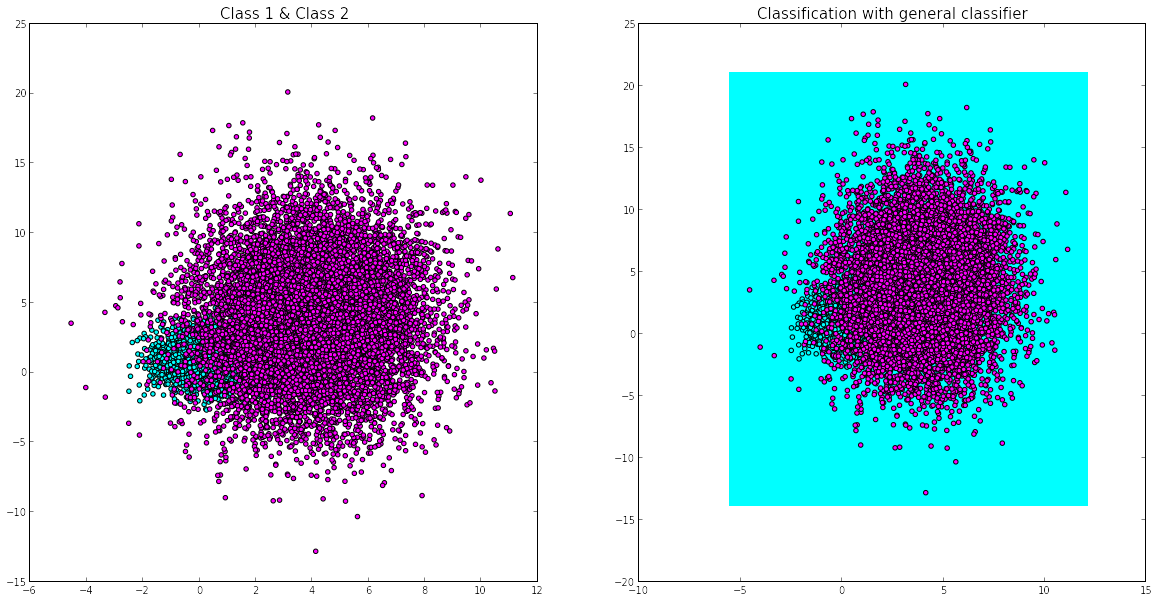

In [89]:
# plot
f, axarr = subplots(1, 2,figsize=(20, 10))
axarr[0].set_title("Class 1 & Class 2", fontsize=15)
axarr[0].scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')

axarr[1].set_title("Classification with general classifier", fontsize=15)
visualize(classifier1, case2_sample_set, labels, axarr[1])

Chernoff bound:
P(error) <= 0.052700
Bhattacharyya bound: 
k(0.5) = 2.250000
P(error) <= 0.052700


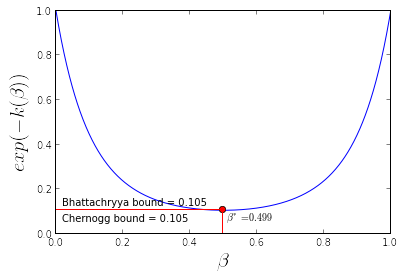

In [78]:
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
cov1 = np.array([[1.,0],[0,1.]])
cov2 = np.array([[4.,0],[0,16.]])
apriori1 = 0.5
apriori2 = 0.5

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value-0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov, cov)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 2. Part B

In [84]:
# classification
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
cov1 = np.array([[1.,0],[0,1.]])
cov2 = np.array([[4.,0],[0,16.]])
apriori1 = 0.2
apriori2 = 0.8

classifier2 = QuadraticDiscriminant(mean1, mean2, cov1, cov2, apriori1, apriori2)

# calc miss classification
calcError(classifier2, case2_sample_set, labels)

# of miss classifications for class1 = 10000
# of miss classifications for class2 = 0
# of miss classifications = 10000


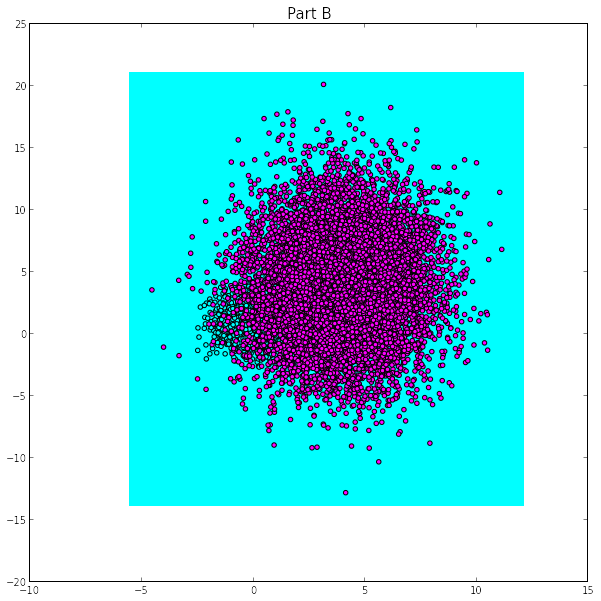

In [80]:
# plot
f, axarr = subplots(figsize=(10,10))
axarr.set_title("Part B", fontsize=15)
axarr.scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')
visualize(classifier2, case2_sample_set, labels, axarr)

Chernoff bound:
P(error) <= 0.048321
Bhattacharyya bound: 
k(0.5) = 2.250000
P(error) <= 0.048300


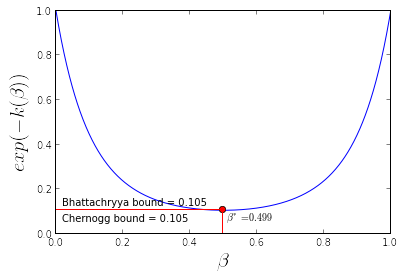

In [81]:
mean1 = np.array([1.,1.])
mean2 = np.array([4.,4.])
cov1 = np.array([[1.,0],[0,1.]])
cov2 = np.array([[4.,0],[0,16.]])
apriori1 = 0.3
apriori2 = 0.7

betas = np.linspace(0,1,1000)
ekbs = []
minekb = None
minbeta = None
ekb_value = None

# calc ekbs
for beta in betas:
    ekb_value = ekb(beta, mean1, mean2, cov, cov)
    if minekb == None or minekb > ekb_value:
        minekb = ekb_value
        minbeta = beta
    ekbs.append(ekb_value)

# plot ekbs bs beta
plot(betas, ekbs)
xlabel(r'$\beta$',fontsize=20)
ylabel(r'$exp(-k(\beta))$',fontsize=20)

beta = minbeta
ekb_value = minekb
plot(beta,ekb_value,'go')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'g')
plot([beta]*2,np.linspace(0,ekb_value,2), 'g')
text(0.02, ekb_value-0.05, "Chernogg bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)
text(beta+0.01, ekb_value-0.05, r"$\beta^*=%.3f$" %(beta),horizontalalignment='left', fontsize=10)

# print upperbounds for probability of error
print "Chernoff bound:"
print r"P(error) <= %f" %(chernoff(minbeta, apriori1, apriori2, ekb_value))

# plot bounds
beta = 0.5
ekb_value = ekb(beta, mean1, mean2, cov, cov)
plot(beta,ekb_value,'ro')
plot(np.linspace(0,beta,2),[ekb_value]*2, 'r')
plot([beta]*2,np.linspace(0,ekb_value,2), 'r')
text(0.02, ekb_value+0.02, "Bhattachryya bound = %.3f" %(ekb_value),horizontalalignment='left', fontsize=10)

print "Bhattacharyya bound: \nk(0.5) = %f" %(-np.log(ekb_value))
print r"P(error) <= %f" %(bhattacharyya(apriori1, apriori2, ekb_value))

# 3.

# of miss classifications for class1 = 182
# of miss classifications for class2 = 2492
# of miss classifications = 2674


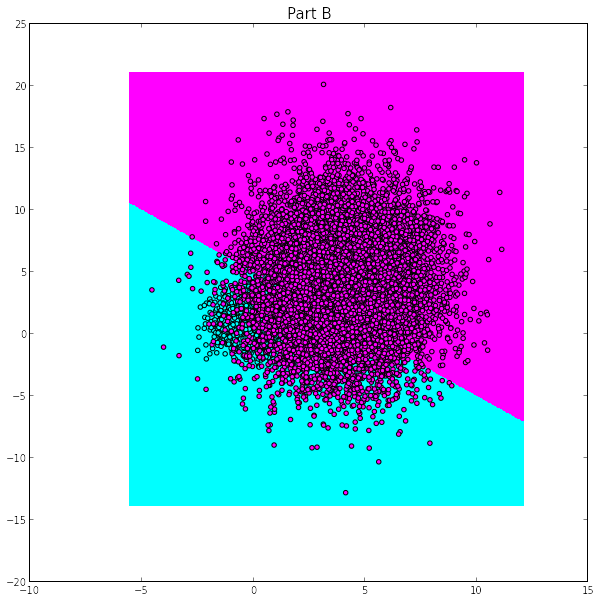

In [82]:
minClassifier = MinDistClassifier(mean1, mean2)

# calc miss classification
calcError(minClassifier, case2_sample_set, labels)

# plot
f, axarr = subplots(figsize=(10,10))
axarr.set_title("Part B", fontsize=15)
axarr.scatter(case2_sample_set[:,0], case2_sample_set[:,1], c=labels, cmap='cool')
visualize(minClassifier, case2_sample_set, labels, axarr)